# Definição do Problema

O objetivo desse projeto foi avaliar o impacto do **early game** no resultado final de partidas de League of Legends, treinar um modelo de machine learning para prever a probabilidade de uma equipe ser vencedora e realizar o deploy na forma de uma aplicação online. Os dados utilizados contém informações referentes aos 10 primeiros minutos de aproximadamente 10.000 partidas rankeadas (do diamante até o mestre) coletadas diretamente da API da Riot Games e disponíveis publicamente no [Kaggle](https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min).

# Importação de pacotes e carregamento dos dados

In [1]:
#gerais
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Machine Learning
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

#tunning
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

plt.style.use("seaborn")

In [2]:
df = pd.read_csv("./data/high_diamond_ranked_10min.csv")

In [3]:
df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


# Análise Exploratória e Engenharia de Atributos

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [5]:
df.shape

(9879, 40)

In [6]:
df.isnull().sum().sum()

0

In [7]:
df.columns

Index(['gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redFirstBlood', 'redKills', 'redDeaths', 'redAssists',
       'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin'],
      dtype='object')

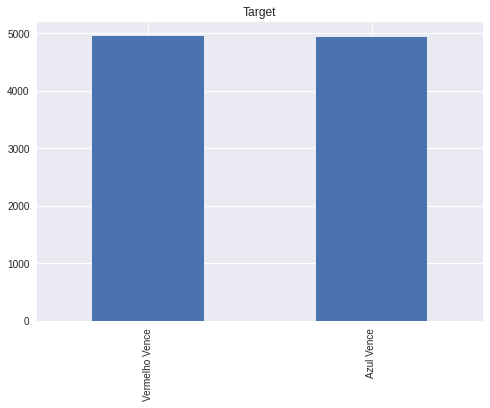

In [8]:
fig, ax1 = plt.subplots()
df.blueWins.value_counts().plot.bar()
ax1.set_xticklabels(["Vermelho Vence", "Azul Vence"])
ax1.set_title("Target")
plt.show()

- Não há valores missing
- Todos os valores são numéricos
- Target balanceada

## Criando novas features

A mesma informação é repetida em cada equipe para todas as features preditoras. Por exemplo, a variável Kills está relacionada com redKills e blueKills. Em todos os casos, criei novas variáveis com a diferença entre elas (Killsdif = blueKills − redKills) afim de manter uma única variável para cada informação. Também criei a variável Wards Restantes com a diferença entre Wards Colocadas e Destruidas.

In [9]:
#separando atributos por time
blue_vars = [blue_var for blue_var in df.columns if "blue" in blue_var]
red_vars = [red_var for red_var in df.columns if "red" in red_var]

#verificando shape esperado para o novo df
print(f"Variáveis time azul (sem blueWins): {len(blue_vars)-1}")
print(f"Variáveis time vermelho: {len(red_vars)}")
print(f"Shape Novo DataFrame: ({df.shape[0]},{len(blue_vars)})")

Variáveis time azul (sem blueWins): 19
Variáveis time vermelho: 19
Shape Novo DataFrame: (9879,20)


In [10]:
new_vars = ["WardsColocas_dif","WardsDestruidas_dif","FirstBlood_dif","Kills_dif","Mortes_dif","Assists_dif",
            "MonstrosElite_dif","Drags_dif","Arautos_dif","Torres_dif","GoldTotal_dif","AvgLevel_dif",
            "TotalExp_dif","TotalMinionsKilled_dif","TotalJungleMinionsKilled_dif","GoldDiff_dif",
            "ExpDiff_dif","CSPorMin_dif","GoldPorMin_dif"]

df_tidy = pd.DataFrame()
for blue_var, red_var, new_var in zip(blue_vars[1:],red_vars, new_vars):
    df_tidy[new_var] = df[blue_var] - df[red_var]

df_tidy["Target"] = df["blueWins"]

In [11]:
df_tidy.shape

(9879, 20)

In [12]:
df_tidy.head()

,WardsColocas_dif,WardsDestruidas_dif,FirstBlood_dif,Kills_dif,Mortes_dif,Assists_dif,MonstrosElite_dif,Drags_dif,Arautos_dif,Torres_dif,GoldTotal_dif,AvgLevel_dif,TotalExp_dif,TotalMinionsKilled_dif,TotalJungleMinionsKilled_dif,GoldDiff_dif,ExpDiff_dif,CSPorMin_dif,GoldPorMin_dif,Target
0,13,-4,1,3,-3,3,0,0,0,0,643,-0.2,-8,-2,-19,1286,-16,-0.2,64.3,0
1,0,0,-1,0,0,3,-2,-1,-1,-1,-2908,-0.2,-1173,-66,-9,-5816,-2346,-6.6,-290.8,0
2,0,-3,-1,-4,4,-10,1,1,0,0,-1172,-0.4,-1033,-17,18,-2344,-2066,-1.7,-117.2,0
3,28,-1,-1,-1,1,-5,1,0,1,0,-1321,0.0,-7,-34,8,-2642,-14,-3.4,-132.1,0
4,58,2,-1,0,0,-1,-1,-1,0,0,-1004,0.0,230,-15,-10,-2008,460,-1.5,-100.4,0


In [13]:
df_tidy.columns

Index(['WardsColocas_dif', 'WardsDestruidas_dif', 'FirstBlood_dif',
       'Kills_dif', 'Mortes_dif', 'Assists_dif', 'MonstrosElite_dif',
       'Drags_dif', 'Arautos_dif', 'Torres_dif', 'GoldTotal_dif',
       'AvgLevel_dif', 'TotalExp_dif', 'TotalMinionsKilled_dif',
       'TotalJungleMinionsKilled_dif', 'GoldDiff_dif', 'ExpDiff_dif',
       'CSPorMin_dif', 'GoldPorMin_dif', 'Target'],
      dtype='object')

In [14]:
#nova feature Wards Restantes
df_tidy["WardsRestantes_dif"] = df_tidy["WardsColocas_dif"] - df_tidy["WardsDestruidas_dif"]

#features redundantes
to_drop = ["WardsColocas_dif", "WardsDestruidas_dif", "Mortes_dif", "MonstrosElite_dif",
           "GoldDiff_dif","GoldPorMin_dif", "ExpDiff_dif","CSPorMin_dif"]

df_tidy.drop(to_drop, axis=1, inplace=True)

df_tidy.shape

(9879, 13)

In [15]:
df_tidy.columns

Index(['FirstBlood_dif', 'Kills_dif', 'Assists_dif', 'Drags_dif',
       'Arautos_dif', 'Torres_dif', 'GoldTotal_dif', 'AvgLevel_dif',
       'TotalExp_dif', 'TotalMinionsKilled_dif',
       'TotalJungleMinionsKilled_dif', 'Target', 'WardsRestantes_dif'],
      dtype='object')

## Visão

In [16]:
print(f" Média de wards colocadas pelo time Azul: {df.blueWardsPlaced.mean():.2f}\n \
Média de wards colocadas pelo time Vermelho: {df.redWardsPlaced.mean():.2f}\n \
Média de wards destruídas pelo time Azul: {df.blueWardsDestroyed.mean():.2f}\n \
Média de wards destruídas pelo time Vermelho: {df.redWardsDestroyed.mean():.2f}")



 Média de wards colocadas pelo time Azul: 22.29
 Média de wards colocadas pelo time Vermelho: 22.37
 Média de wards destruídas pelo time Azul: 2.82
 Média de wards destruídas pelo time Vermelho: 2.72


<Figure size 576x396 with 0 Axes>

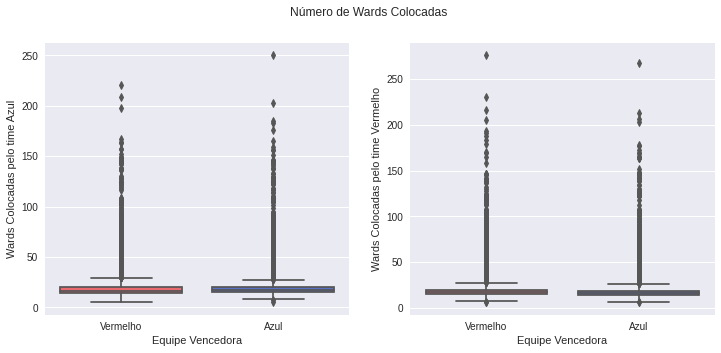

In [17]:
my_pal = {0: (255/255, 86/255, 91/255, 0.73), 1: (70/255, 104/255, 215/255, 0.51)}

fig = plt.figure()
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,5))
fig.suptitle("Número de Wards Colocadas", fontsize = 12)
sns.boxplot(data=df, y="blueWardsPlaced",x = "blueWins", ax=ax1, palette=my_pal)
sns.boxplot(data=df, y="redWardsPlaced", x = "blueWins", ax=ax2, palette=my_pal )

ax1.set_ylabel("Wards Colocadas pelo time Azul")
ax1.set_xlabel("Equipe Vencedora")
ax1.set_xticklabels(["Vermelho", "Azul"])

ax2.set_ylabel("Wards Colocadas pelo time Vermelho")
ax2.set_xlabel("Equipe Vencedora")
ax2.set_xticklabels(["Vermelho", "Azul"])


plt.show()

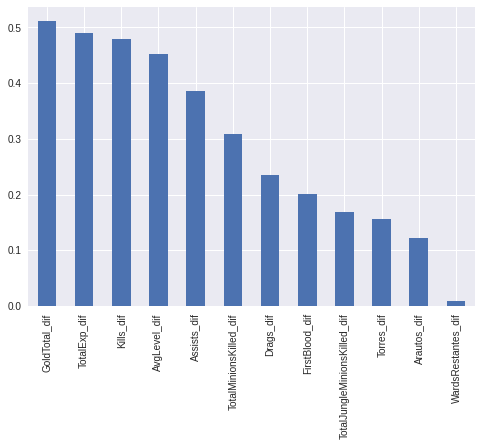

In [18]:
# Correlação com Target
ax = abs(df_tidy.corr()["Target"]).sort_values(ascending = False)[1:].plot.bar()
plt.show()

- Em média, as equipes tiveram um número similar de Wards colocadas e destruídas por partida

- Apesar de visão ser conhecido como um fator chave em League of Legends, o número de Wards restantes apresentou baixa correlação com o resultado final. Provavelmente devido ao mapa não estar totalmente aberto no começo do jogo, diminuindo a importância nos minutos iniciais em contraste com o late game onde porções do mapa sem visão possibilitam pick offs (ou emboscadas) que podem levar a teamfights determinantes para vitória ou derrota.

- Há um número significativo de outliers. Para atingir 250 wards nos primeiros 10 minutos de jogo cada jogador deveria colocar 5 wards por minuto. Considerando que o item de suporte (normalmente a posição com maior responsabilidade de fornecer visão a equipe) possui 3 vagas para wards, esses valores são dificeis de ser alcançados. Uma hipótese é que houve desistência de uma das equipes com os jogadores ficando parados na base colocando wards a todo instante aguardando o avanço do adversário (prática relativamente comum).



## Monstros Elite (Barão + Arauto)

<Figure size 576x396 with 0 Axes>

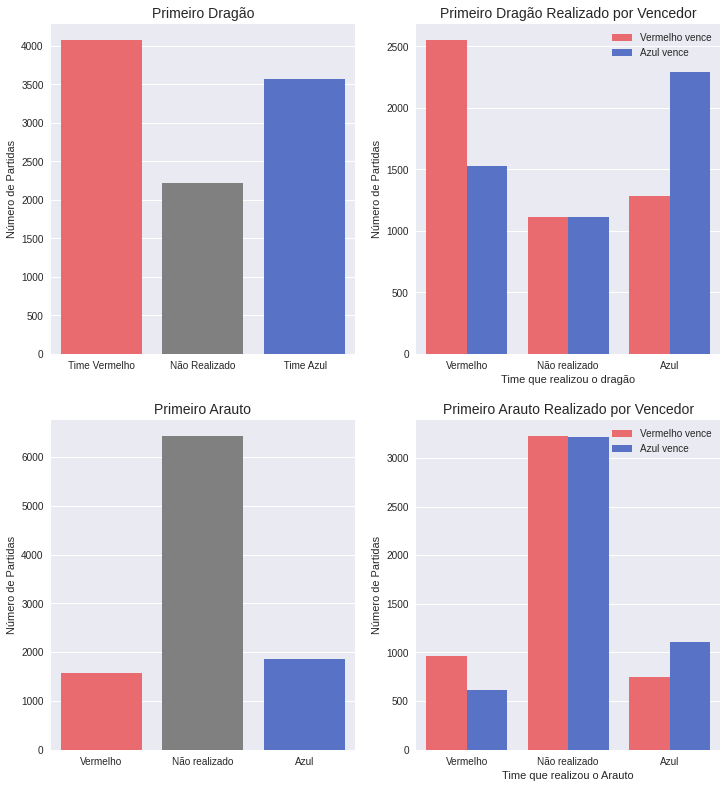

In [19]:
fig = plt.figure()
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (12,12))

fig.subplots_adjust(top = 0.92, bottom = 0.08)


sns.countplot(data= df_tidy, x = "Drags_dif", ax=ax1, palette=((255/255, 86/255, 91/255, 0.73),"grey",(70/255, 104/255, 215/255, 0.51)))
ax1.set_title("Primeiro Dragão", size =14)
ax1.set_xticklabels(["Time Vermelho","Não Realizado"," Time Azul"])
ax1.set_xlabel("")
ax1.set_ylabel("Número de Partidas")


sns.countplot(data=df_tidy, x = "Drags_dif", hue="Target", ax=ax2, palette=my_pal)
ax2.set_title("Primeiro Dragão Realizado por Vencedor", size = 14)
ax2.legend(["Vermelho vence", "Azul vence"], title = "")
ax2.set_xlabel("Time que realizou o dragão")
ax2.set_xticklabels(["Vermelho", "Não realizado", "Azul"])
ax2.set_ylabel("Número de Partidas")

sns.countplot(data=df_tidy, x = "Arautos_dif", ax=ax3, palette=((255/255, 86/255, 91/255, 0.73),"grey",(70/255, 104/255, 215/255, 0.51)))
legend_labels, _= ax3.get_legend_handles_labels()
ax3.set_title("Primeiro Arauto", size = 14)
ax3.set_xlabel("")
ax3.set_xticklabels(["Vermelho", "Não realizado", "Azul"])
ax3.set_ylabel("Número de Partidas")


sns.countplot(data=df_tidy, x = "Arautos_dif", hue="Target", ax=ax4, palette=my_pal)
ax4.set_title("Primeiro Arauto Realizado por Vencedor", size=14)
ax4.legend(["Vermelho vence", "Azul vence"], title = "")
ax4.set_xlabel("Time que realizou o Arauto")
ax4.set_xticklabels(["Vermelho", "Não realizado", "Azul"])
ax4.set_ylabel("Número de Partidas")
plt.savefig("EliteMonsters.png")
plt.show()

 - Curiosamente, o time azul realizou menos dragões que o vermelho mesmo com vantagem de mapa (o pitch do dragão fica mais perto da base azul)
- O dragão é um objetivo bem mais disputado que o arauto no early game.
- A Equipe que realiza o primeiro dragão tende a obter mais vitórias. Embora isso não signifique que os dragões sejam a causa da vitória (muito provavelmente não são).
- O mesmo acontece (em menor proporção) com o primeiro arauto.

## Torres destruidas

<Figure size 576x396 with 0 Axes>

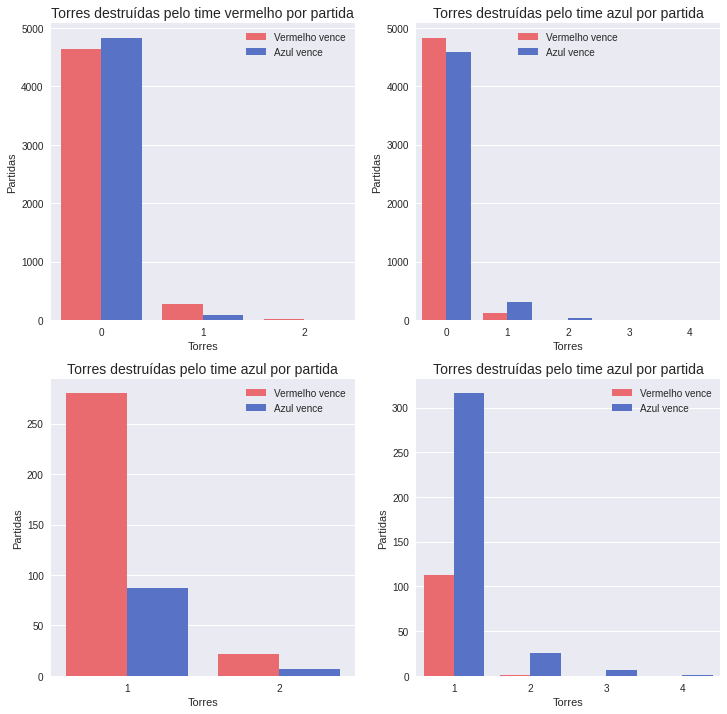

In [20]:
df_redt = df.groupby(by=["blueWins","redTowersDestroyed"]).size().reset_index(name = "count")
df_bluet = df.groupby(by=["blueWins","blueTowersDestroyed"]).size().reset_index(name = "count")

fig = plt.figure()
fig.subplots_adjust(top = 0.92, bottom = 0.08)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (12,12))
sns.barplot(data = df_redt, x = "redTowersDestroyed", y = "count", hue = "blueWins", ax=ax1, palette=my_pal)
legend_labels, _= ax1.get_legend_handles_labels()
ax1.legend(legend_labels,["Vermelho vence", "Azul vence"], title = "")
ax1.set_xlabel("Torres")
ax1.set_ylabel("Partidas")
ax1.set_title("Torres destruídas pelo time vermelho por partida", size = 14)


sns.barplot(data = df_bluet, x = "blueTowersDestroyed", y = "count", hue = "blueWins", ax=ax2, palette=my_pal)
ax2.legend(legend_labels,["Vermelho vence", "Azul vence"], title = "")
ax2.set_xlabel("Torres")
ax2.set_ylabel("Partidas")
ax2.set_title("Torres destruídas pelo time azul por partida", size = 14)

sns.barplot(data=df_redt[df_redt.redTowersDestroyed > 0],x = "redTowersDestroyed", y = "count", hue = "blueWins", palette=my_pal, ax=ax3)
ax3.legend(legend_labels,["Vermelho vence", "Azul vence"], title = "")
ax3.set_xlabel("Torres")
ax3.set_ylabel("Partidas")
ax3.set_title("Torres destruídas pelo time azul por partida", size = 14)

sns.barplot(data=df_bluet[df_bluet.blueTowersDestroyed > 0],x = "blueTowersDestroyed", y = "count", hue = "blueWins", palette=my_pal, ax=ax4)
ax4.legend(legend_labels,["Vermelho vence", "Azul vence"], title = "")
ax4.set_xlabel("Torres")
ax4.set_ylabel("Partidas")
ax4.set_title("Torres destruídas pelo time azul por partida", size = 14)



plt.show()


- Na maior parte das partidas nenhuma equipe destruiu torres nos 10 primeiros minutos.
- Destruir torres parece estar associado a uma maior taxa de vitória.
- Algumas partidas tiveram um número anormal de torres destruídas, possivelmente casos de stomps (quando uma equipe abre muita vantagem em relação ao oponente) ou desistência.

## Gold, Kills, Experiência e Farm

In [21]:
df_tidy.columns

Index(['FirstBlood_dif', 'Kills_dif', 'Assists_dif', 'Drags_dif',
       'Arautos_dif', 'Torres_dif', 'GoldTotal_dif', 'AvgLevel_dif',
       'TotalExp_dif', 'TotalMinionsKilled_dif',
       'TotalJungleMinionsKilled_dif', 'Target', 'WardsRestantes_dif'],
      dtype='object')

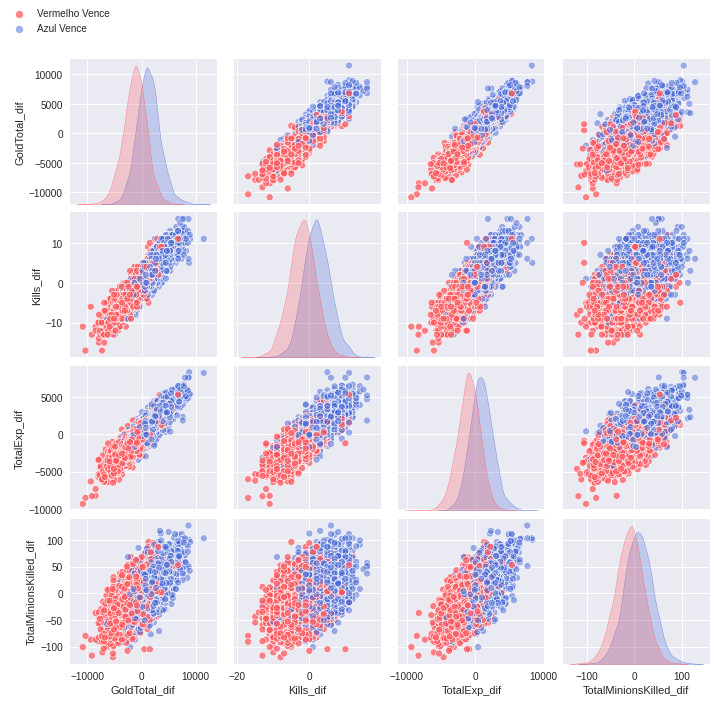

In [22]:
g = sns.pairplot(data = df_tidy[["GoldTotal_dif", "Kills_dif", "TotalExp_dif", "TotalMinionsKilled_dif","Target"]], 
                 hue="Target", palette=my_pal)
g._legend.remove()
handles = g._legend_data.values()
g.fig.legend(handles = handles, labels = ["Vermelho Vence", "Azul Vence"], loc='upper left')
g.fig.subplots_adjust(top=0.92, bottom=0.08)

- Conforme esperado, ficar atrás em Gold, Exp, Kills, e Farm diminui a perspectiva de vitória. Entretanto, é possível observar algumas partidas que terminam em vitória da equipe em desvantagem nesses atributos.
- A Correlação foi positiva em todos os confrontos de variáveis.
- Distribuições se assemelham a gaussiana, logo modelos paramétricos podem ser benéficos.

# Seleção do Modelo

In [17]:
#Isolando a variável target(y) das preditoras(X)
X = df_tidy.drop(["Target"], axis = 1)
y = df_tidy["Target"]

#Divisão em treino (80% dos dados) e teste (20% dos dados)
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,shuffle=True, stratify=y, random_state=32)

#Número de folds para cross validation: 10 fols com 5 repetições.
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=32)

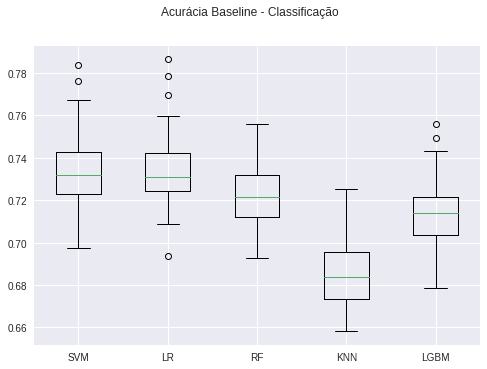

In [23]:
#Inicializando listas vazias que receberão os resultados finais e instâncias dos modelos 
labels = []
modelos = []
cv_scores = []
test_scores = []

modelos.append(("SVM", SVC(kernel="linear",random_state=32)))
modelos.append(("LR", LogisticRegression(max_iter=1000, solver="liblinear", random_state=32)))
modelos.append(("RF", RandomForestClassifier(n_estimators=200, random_state=32)))
modelos.append(("KNN", KNeighborsClassifier()))
modelos.append(("LGBM", LGBMClassifier(n_estimators=200, random_state=32)))

#Inicializando o loop
for label, modelo in modelos:
    
    #cross validation: padronização com StandartScaler
    labels.append(label)
    pipe = make_pipeline(StandardScaler(),modelo)
    scores = cross_val_score(pipe,X_train,y_train, scoring="accuracy", cv=cv)
    cv_scores.append(scores)
    
    #avaliação em teste para verificar generalização
    pipe.fit(X_train,y_train)
    test_score = accuracy_score(y_test, pipe.predict(X_test))
    test_scores.append(test_score)
    
#plot    
fig = plt.figure()
fig.suptitle('Acurácia Baseline - Classificação')
ax = fig.add_subplot(111)
plt.boxplot([i for i in cv_scores])
ax.set_xticklabels(labels)
plt.show()

In [24]:
for label, cv, test in zip(labels, cv_scores, test_scores):
    print(f"{label}\tCV: {cv.mean():.5f}\tTest: {test:.5f}\t Dif: {cv.mean() - test:.5f}")

SVM	CV: 0.73420	Test: 0.71660	 Dif: 0.01760
LR	CV: 0.73473	Test: 0.72014	 Dif: 0.01459
RF	CV: 0.72178	Test: 0.70192	 Dif: 0.01985
KNN	CV: 0.68528	Test: 0.67611	 Dif: 0.00917
LGBM	CV: 0.71360	Test: 0.69889	 Dif: 0.01471


In [25]:
print(f"Baseline de: {cv_scores[1].mean():.5f} ± {cv_scores[1].std():.5f}(CV) e \
{test_scores[1]:.5f}(Test) com Logistic Regression")

Baseline de: 0.73473 ± 0.01738(CV) e 0.72014(Test) com Logistic Regression


# Tunning de hiperparâmetros

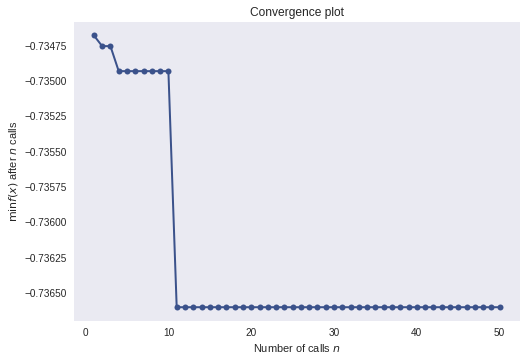

In [18]:
#restartar o kernel apos a cross validation antes de executar 

#modelo
clf = LogisticRegression(random_state=32, solver="liblinear")

#espaço de hiperparâmetros, busca será relaizada entre (min,max) dos valores numéricos
space = [
    Categorical(["l1","l2"], name="penalty"),
    Real(0.0001, 0.001, name="tol"),
    Real(0.01,10, name="C"),
    Integer(100,1000, name="max_iter")
]
#definição do pipeline 
pipe = make_pipeline(StandardScaler(), clf)

#utilitário que permite passar parâmetros do scikit-learn diretamente como argumento.
@use_named_args(space)

# função a ser minimizada 
def objective(**params):
    pipe[1].set_params(**params)  ## ou passar o clf direto
    return -np.mean(cross_val_score(pipe, X_train, y_train, cv=cv, n_jobs=-1,
                                    scoring="accuracy"))

# instância do gp_minimize, a cada 10 iterações a busca é guiada pelo modelo.
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0, n_initial_points=10, n_jobs=-1)

plot_convergence(res_gp)
plt.show()

Após 10 iterações o gp_minimize alcança um valor minimo e permanece nele até o fim das 50 iterações definidas

In [19]:
# melhor score obtido
abs(res_gp.fun)

0.7366043943734099

In [20]:
# melhore combinação de hiperparâmetros
res_gp.x

['l1', 0.001, 0.01, 345]

In [21]:
#avaliação em teste do modelo tunado
clf = LogisticRegression(solver="liblinear",penalty="l1",tol = 0.001, C=0.01, max_iter= 345,
                         random_state=32)

pipe = make_pipeline(StandardScaler(), clf)
pipe.fit(X_train, y_train)

accuracy_score(y_test, pipe.predict(X_test))

0.722165991902834

# Seleção de Features

In [38]:
clf = LogisticRegression(solver="liblinear",penalty="l1",tol = 0.001, C=0.01, max_iter= 345,
                         random_state=32)
score = []

## Loop para treinar modelos com 2 a 11 features
for n in range(2,X.shape[1]):
    pipe = make_pipeline(StandardScaler(), SelectFromModel(clf, threshold= - np.inf, max_features=n), clf)
    cv_score = cross_val_score(pipe,X_train,y_train, cv=cv, n_jobs=-1, scoring="accuracy")
    score.append(cv_score.mean())
    pipe.fit(X_train,y_train)
    test = accuracy_score(y_test, pipe.predict(X_test))
    print(f"{n} features - CV: {np.mean(cv_score):.6f} - test: {test:.6f}")

2 features - CV: 0.730329 - test: 0.714069
3 features - CV: 0.736554 - test: 0.722672
4 features - CV: 0.736452 - test: 0.722672
5 features - CV: 0.736376 - test: 0.722166
6 features - CV: 0.736351 - test: 0.722672
7 features - CV: 0.736452 - test: 0.722166
8 features - CV: 0.736503 - test: 0.722166
9 features - CV: 0.736301 - test: 0.722166
10 features - CV: 0.736503 - test: 0.722166
11 features - CV: 0.736478 - test: 0.722166


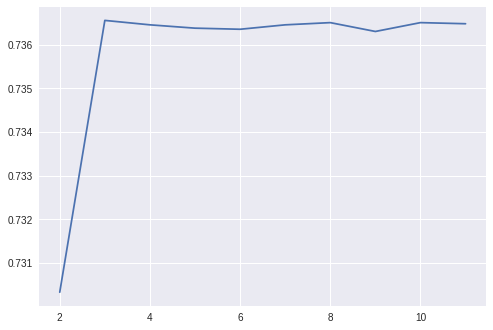

In [39]:
pd.Series(score, index=range(2,X.shape[1])).plot()
plt.show()

O maior score obtido na validação cruzada e nos dados de teste foi no modelo treinado com 3 features. Entretanto, a diferença para a iteração anterior (2) foi muito brusca. A região próxima a 4 features apresentou o mesmo score em teste com uma maior "estabilidade", sem subidas ou descidas muito acentuadas. Por isso, n = 4 foi escolhido.

In [34]:
#get_support retorna um array booleano correspondente as features que passaram no corte do SelectFromModel
mask = pipe[1].get_support()
X_train.columns[mask]

Index(['FirstBlood_dif', 'Kills_dif', 'Assists_dif', 'Drags_dif',
       'Arautos_dif', 'Torres_dif', 'GoldTotal_dif', 'AvgLevel_dif',
       'TotalExp_dif', 'TotalMinionsKilled_dif',
       'TotalJungleMinionsKilled_dif'],
      dtype='object')

<AxesSubplot:>

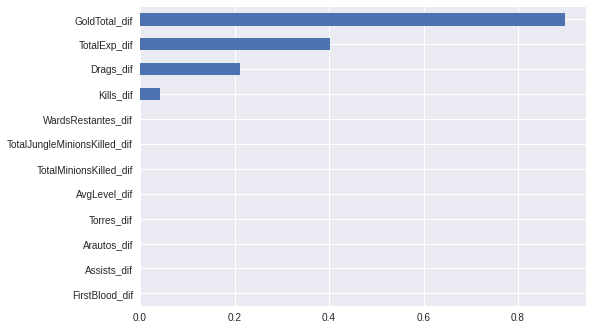

In [35]:
# Plotando Features por ordem de importância de acordo com os coeficientes da Logit
pd.Series(abs(pipe[1].estimator_.coef_[0]) , index=X_train.columns).sort_values(ascending=True).plot.barh()

In [36]:
#coeficientes
pipe[1].estimator_.coef_[0]

array([0.        , 0.04253331, 0.        , 0.21160083, 0.        ,
       0.        , 0.8999377 , 0.        , 0.40221591, 0.        ,
       0.        , 0.        ])

# Considerações Finais

In [37]:
clf_final = LogisticRegression(solver="liblinear",penalty="l1",tol = 0.001, C=0.01, max_iter= 345,
                         random_state=32)

pipe_final = make_pipeline(StandardScaler(), SelectFromModel(clf, threshold= - np.inf, max_features=4), clf_final)

index = ["baseline", "tunning","tunning + feature_selection"]
pd.DataFrame({"CV":[0.73473,0.73660,0.73645],
             "Test":[0.72014,0.72216,0.72267]}, index=index)

,CV,Test
baseline,0.73473,0.72014
tunning,0.73660,0.72216
tunning + feature_selection,0.73645,0.72267


 - O modelo final apresentou mais de 70% de acurácia em prever o resultado de partidas de League of Legends apenas com informações referentes aos 10 primeiros minutos de jogo, o que mostra a relevância dessa etapa no game no resultado final.
- Gold, Experiência, o Dragão e Abates parecem ser os fatores mais impactantes no início do jogo.
- Visão não se mostrou um atributo relevante no começo do jogo, embora espera-se que sua importância aumente com o passar dos minutos.
- O Dragão é um objetivo bem mais visado que o Arauto

# Referências

Cross Validation:

- [Training-validation-test split and cross-validation done right](https://machinelearningmastery.com/training-validation-test-split-and-cross-validation-done-right/)

Feature Selection:

 - [A forma mais simples de selecionar as melhores variáveis usando Scikit-learn (Mario Filho Brasil)](https://www.youtube.com/watch?v=Bcn5e7LYMhg)
 - [Documentação do sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html)
 
Tunning por infereência baesiana

- [Nunca Use Grid Search Para Ajustar Hiperparâmetros (Mario Filho Brasil)](https://www.youtube.com/watch?v=WhnkeasZNHI)
- [Documentação do Skop](https://scikit-optimize.github.io/stable/auto_examples/hyperparameter-optimization.html#sphx-glr-auto-examples-hyperparameter-optimization-py)
- [Alternative Hyperparameter Optimization Techniques You Need to Know — Part 2](https://medium.datadriveninvestor.com/alternative-hyperparameter-optimization-techniques-you-need-to-know-part-2-e9b0d4d080a9)

Regressão Logística e Regularização

- [Mãos à obra: aprendizado de máquina com Scikit-Learn, Keras & TensorFlow (Cap.4 Treinando Modelos)](https://www.amazon.com.br/M%C3%A3os-Obra-Aprendizado-Scikit-Learn-Inteligentes-ebook/dp/B09H13N8FN/ref=sr_1_1?__mk_pt_BR=%C3%85M%C3%85%C5%BD%C3%95%C3%91&crid=FT8BT7PB9B41&keywords=M%C3%A3os+%C3%A0+Obra%3A+Aprendizado+de+M%C3%A1quina&qid=1646168297&s=digital-text&sprefix=m%C3%A3os+%C3%A0+obra+aprendizado+de+m%C3%A1quina%2Cdigital-text%2C194&sr=1-1)
